In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

/root/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 32
input_size = 4
hidden_size = 8
num_layers = 1
num_classes = 3
num_epochs = 100

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## 1. 准备数据

In [4]:
# 加载鸢尾花数据集
iris = load_iris()
X = iris.data
y = iris.target

In [5]:
X_train, X_test, y_train, y_test = train_test_split(iris.data,iris.target,test_size=0.2, random_state=42)

In [19]:
y_test.shape

(30,)

In [6]:
# 定义数据集
class IrisDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [7]:
# 创建数据集对象
train_dataset = IrisDataset(X_train, y_train)
test_dataset = IrisDataset(X_test, y_test)

In [8]:
# 创建数据加载器
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## 2. LSTM模型

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [10]:
model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

## 3. 定义损失函数和优化器

In [11]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## 4. 训练模型

In [12]:
Loss = []
for epoch in range(num_epochs):
    for i, (X, y) in enumerate(train_dataloader):
        X = X.view(-1, 1, 4).float().to(device); y = y.long().to(device)
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)
        Loss.append(loss.tolist())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, len(iris_dataset)//32, loss.item()))
   
    if (epoch+1) % 10 == 0:
        
        with torch.no_grad():
            correct = 0
            total = 0
            for X, y in train_dataloader:
                X = X.view(-1, 1, 4).float().to(device); y = y.long().to(device)
                outputs = model(X)
                _, predicted = torch.max(outputs.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

        print('Epoch [{}/{}], Acc: {:.4f}'.format(epoch+1, num_epochs, 100 * correct / total))

Epoch [10/100], Acc: 93.3333
Epoch [20/100], Acc: 97.5000
Epoch [30/100], Acc: 97.5000
Epoch [40/100], Acc: 97.5000
Epoch [50/100], Acc: 96.6667
Epoch [60/100], Acc: 96.6667
Epoch [70/100], Acc: 97.5000
Epoch [80/100], Acc: 98.3333
Epoch [90/100], Acc: 97.5000
Epoch [100/100], Acc: 98.3333


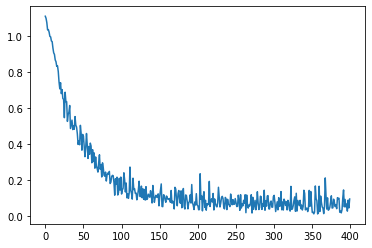

In [13]:
import matplotlib.pyplot as plt
plt.plot(Loss)

## 5. 模型评估

In [14]:
# 模型评估
with torch.no_grad():
    correct = 0
    total = 0
    for X, y in test_dataloader:
        X = X.view(-1, 1, 4).float().to(device); y = y.long().to(device)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

    print('Accuracy of the model on the test data: {} %'.format(100 * correct / total))

Accuracy of the model on the test data: 100.0 %


> 在 PyTorch 中，损失函数和神经网络的输出通常都是浮点数，而标签一般是整数。所以在这里，我们需要将标签数据转换为 `long` 类型。
>
> 需要注意的是在 Pytorch 中，long 类型是 `int64`，而在 Numpy 中，`int64` 是 `int32`,这可能导致一些错误。 所以通常我们使用 `.long()` 来将numpy `int64` 转为 torch `int64`,防止报错